# Lung cancer CXR classification
- Fastai
- densenet121
- Resolution: 224x224

In [1]:
from fastai.vision.all import *
from PIL import Image, ImageOps
from fastai.vision.widgets import *

In [2]:
!nvidia-smi

Wed Aug 16 16:02:37 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      On | 00000000:3D:00.0 Off |                  N/A |
| 32%   50C    P2               93W / 250W|  10852MiB / 11264MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
torch.cuda.set_device(2)

In [4]:
stats = ([0.56, 0.56, 0.56],[0.27, 0.27, 0.27])
#imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [5]:
def HImageBlock():  # For DataBlock
    return TransformBlock(type_tfms=PILImage.create, item_tfms=[Resize(224)],
                          batch_tfms=[IntToFloatTensor, *aug_transforms(do_flip=False, size=224), Normalize.from_stats(*stats)])

In [6]:
dblock = DataBlock(blocks=(HImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   splitter=GrandparentSplitter(valid_name='val'),
                   get_y=parent_label)

In [7]:
training = Path('/data/home/xmonzonis/lung_CXR/LungX_V1/')

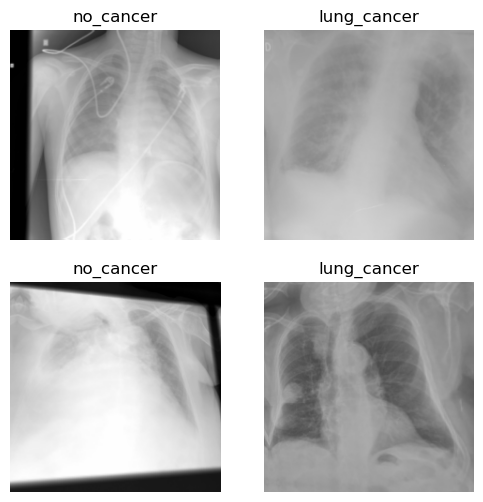

In [21]:
dls = dblock.dataloaders(training, bs=16, num_workers=4)
dls.show_batch(max_n=4)

In [23]:
dls.valid.vocab

['lung_cancer', 'no_cancer']

In [24]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.0256, 0.0256, 0.0256], device='cuda:2'),
 TensorImage([0.8249, 0.8249, 0.8249], device='cuda:2'))

## Training

In [25]:
learn = vision_learner(dls, densenet121, metrics=[accuracy, RocAucBinary()], pretrained=True).to_fp16()

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.516736,0.313823,0.882353,0.961146,05:37
1,0.523116,0.226852,0.923203,0.968566,05:45
2,0.449873,0.257478,0.890523,0.959075,05:40
3,0.377236,0.208368,0.908497,0.974868,04:26
4,0.272402,0.183389,0.929739,0.980052,04:22
5,0.350868,0.182850,0.936275,0.978078,04:20
6,0.294213,0.190428,0.923203,0.979760,04:33
7,0.380289,0.157383,0.947712,0.983372,04:56
8,0.301589,0.189818,0.929739,0.982070,05:09
9,0.303882,0.161559,0.937908,0.987504,04:50


Better model found at epoch 0 with roc_auc_score value: 0.9611463033668864.


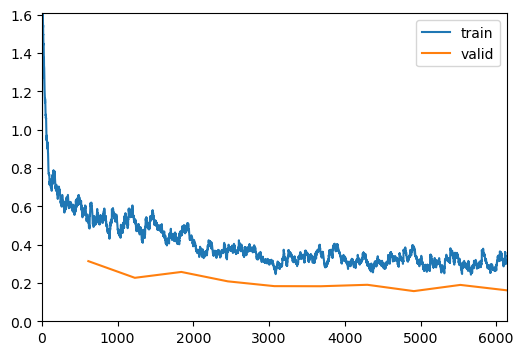

Better model found at epoch 1 with roc_auc_score value: 0.9685656022214509.
Better model found at epoch 3 with roc_auc_score value: 0.9748676674765707.
Better model found at epoch 4 with roc_auc_score value: 0.9800524991322458.
Better model found at epoch 7 with roc_auc_score value: 0.9833716591461298.
Better model found at epoch 9 with roc_auc_score value: 0.98750433877126.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.237956,0.129642,0.946078,0.988340,04:18
1,0.229498,0.142255,0.933007,0.989272,04:19
2,0.200466,0.161542,0.934641,0.985194,04:19
3,0.236072,0.145216,0.939542,0.987602,04:19
4,0.241291,0.145963,0.934641,0.989500,04:48
5,0.236190,0.167951,0.929739,0.982894,04:20
6,0.252450,0.128766,0.955882,0.991474,04:20
7,0.256803,0.117536,0.959150,0.993025,04:21
8,0.256115,0.174086,0.936275,0.989858,04:18
9,0.196063,0.109773,0.957516,0.992857,04:25


Better model found at epoch 0 with roc_auc_score value: 0.988339552238806.


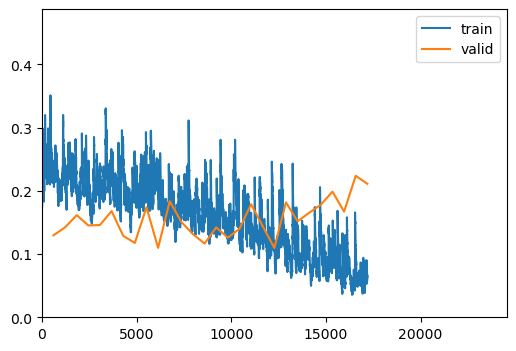

Better model found at epoch 1 with roc_auc_score value: 0.9892723880597015.
Better model found at epoch 4 with roc_auc_score value: 0.9895001735508504.
Better model found at epoch 6 with roc_auc_score value: 0.9914743144741409.
Better model found at epoch 7 with roc_auc_score value: 0.9930254251995835.
Better model found at epoch 13 with roc_auc_score value: 0.9947175459909754.
No improvement since epoch 13: early stopping


In [34]:
learn.fine_tune(40, freeze_epochs=10,
                cbs=[EarlyStoppingCallback(monitor='roc_auc_score', patience=15),
                     ShowGraphCallback(),
                     SaveModelCallback(monitor='roc_auc_score', with_opt=True, 
                                       fname='fastai2_LungCancer_v1_densenet121_fp16')])

## Test

In [35]:
learn = learn.load('fastai2_LungCancer_v1_densenet121_fp16')

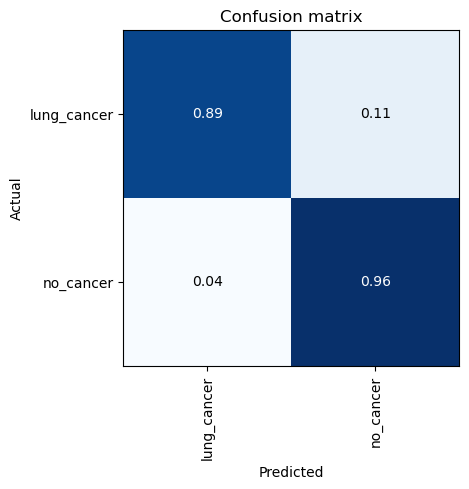

In [36]:
test_set = Path('/data/home/xmonzonis/lung_CXR/LungX_V1/test')
images_test = get_image_files(test_set)
learn.dls.loaders.append(dls.test_dl(list(images_test), with_labels=True))
interp = ClassificationInterpretation.from_learner(learn, ds_idx=2)
interp.plot_confusion_matrix(normalize=True)

In [37]:
interp.print_classification_report()

              precision    recall  f1-score   support

 lung_cancer       0.95      0.89      0.92       268
   no_cancer       0.92      0.96      0.94       364

    accuracy                           0.93       632
   macro avg       0.93      0.93      0.93       632
weighted avg       0.93      0.93      0.93       632



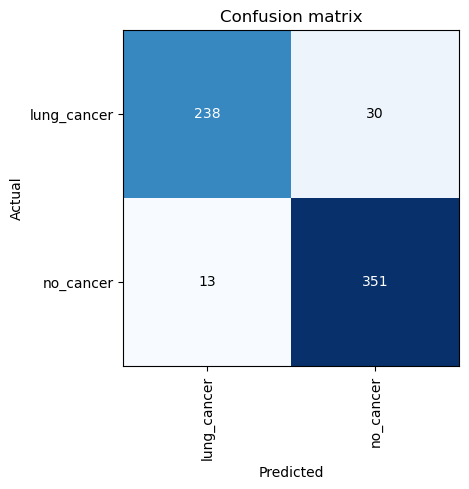

In [38]:
interp.plot_confusion_matrix(normalize=False)

In [39]:
from sklearn.metrics import roc_auc_score

# Load the test dataset
test_set = Path('/data/home/xmonzonis/lung_CXR/LungX_V1/test')
images_test = get_image_files(test_set)
test_dl = dls.test_dl(list(images_test), with_labels=True)

# Get the predictions and true labels for the test dataset
preds, targets = learn.get_preds(dl=test_dl)

# Compute the AUC score
auc_score = roc_auc_score(targets, preds[:, 1])  # Assuming binary classification, use preds[:, 1] for positive class predictions

print("AUC score:", auc_score)

AUC score: 0.9899540757749713


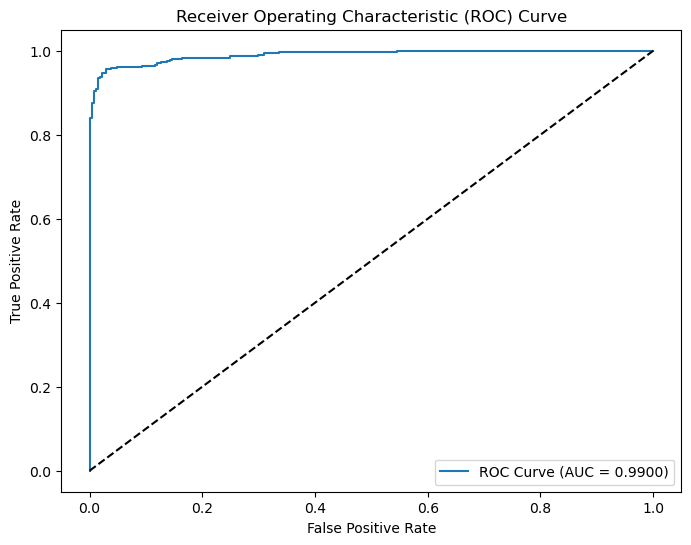

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(targets, preds[:, 1])  # Assuming binary classification, use preds[:, 1] for positive class predictions

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import precision_recall_curve, auc

# Load the test dataset
test_set = Path('/data/home/xmonzonis/lung_CXR/LungX_V1/test')
images_test = get_image_files(test_set)
test_dl = dls.test_dl(list(images_test), with_labels=True)

# Get the predictions and true labels for the test dataset
preds, targets = learn.get_preds(dl=test_dl)

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(targets, preds[:, 1])  # Assuming binary classification, use preds[:, 1] for positive class predictions

# Compute PR AUC
pr_auc = auc(recall, precision)

print("Precision-Recall AUC:", pr_auc)

Precision-Recall AUC: 0.9935212370848994


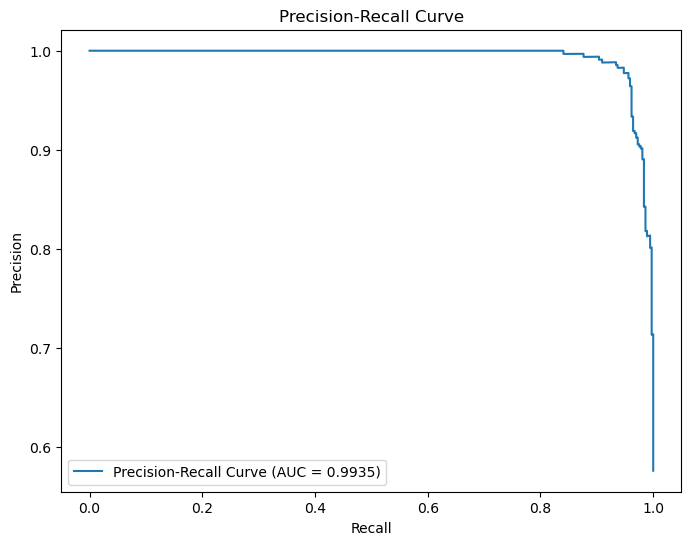

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(targets, preds[:, 1])  # Assuming binary classification, use preds[:, 1] for positive class predictions

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve (AUC = {:.4f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

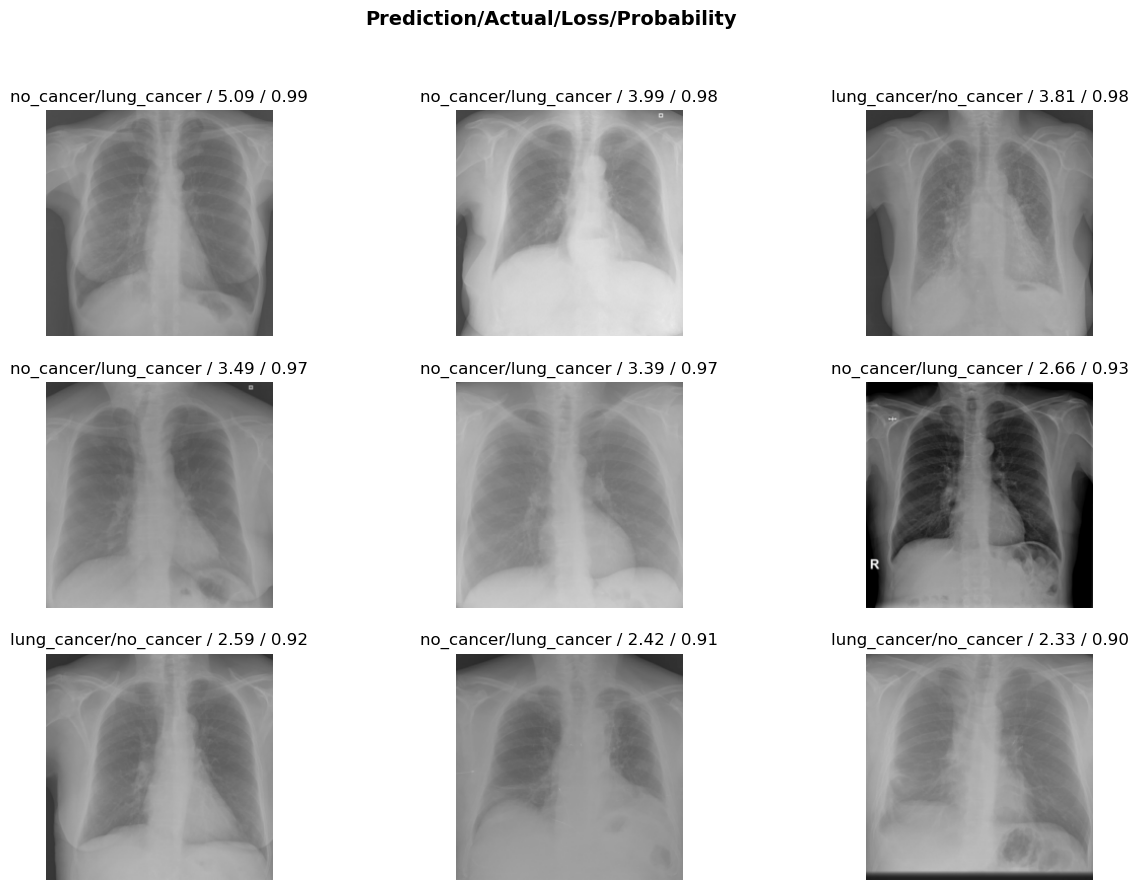

In [43]:
interp.plot_top_losses(9, figsize=(15,10))

In [44]:
from fastai_amalgam.interpret.all import *

good calls

/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default

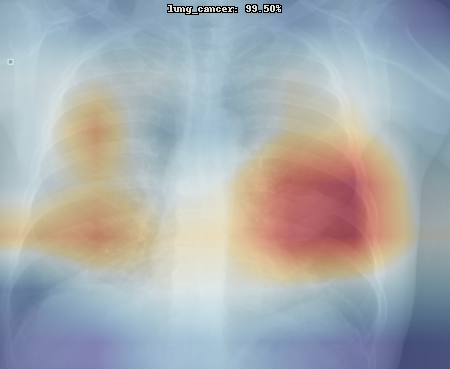

In [45]:
learn.gradcam('/data/home/xmonzonis/lung_CXR/LungX_V1/test/lung_cancer/95160_CR.1.3.51.0.7.320254754.22501.64321.33764.31146.62878.46338.jpeg')

/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default

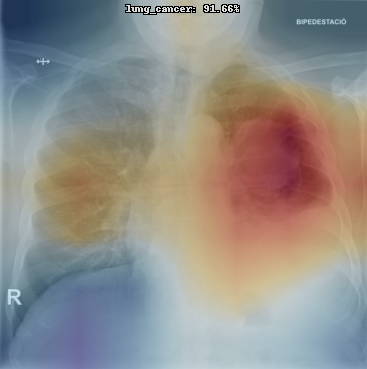

In [46]:
learn.gradcam('/data/home/xmonzonis/lung_CXR/LungX_V1/test/lung_cancer/183542_CR.1.3.12.2.1107.5.3.49.27903.11.202102170105030355.jpeg')

In [47]:
# Get the top loss images and their indexes
losses, indexes = interp.top_losses(9)

# Access the underlying dataloader
dataloader = interp.dl

# Get the dataset associated with the dataloader
dataset = dataloader.dataset

# Retrieve the image paths or names using the dataset
image_paths = [dataset.items[i] for i in indexes]

# Print the image paths or names
print(image_paths)

[Path('/data/home/xmonzonis/lung_CXR/LungX_V1/test/lung_cancer/1538604_CR.1.3.51.0.7.11425924586.27791.12874.38428.42014.46376.59814.jpeg'), Path('/data/home/xmonzonis/lung_CXR/LungX_V1/test/lung_cancer/94362_CR.1.3.51.0.7.14130257803.42652.45636.38951.22749.11815.13775.jpeg'), Path('/data/home/xmonzonis/lung_CXR/LungX_V1/test/no_cancer/7771_CR.1.3.51.0.7.3896945848.37088.4686.41603.16465.36597.867.jpeg'), Path('/data/home/xmonzonis/lung_CXR/LungX_V1/test/lung_cancer/909618_CR.1.3.51.0.7.14258216662.8336.9025.40827.37654.33342.53158.jpeg'), Path('/data/home/xmonzonis/lung_CXR/LungX_V1/test/lung_cancer/745697_CR.1.3.51.0.7.1144491739.7944.58696.34619.32737.14621.59194.jpeg'), Path('/data/home/xmonzonis/lung_CXR/LungX_V1/test/lung_cancer/201468_CR.1.3.12.2.1107.5.3.49.27903.11.202112220934250601.jpeg'), Path('/data/home/xmonzonis/lung_CXR/LungX_V1/test/no_cancer/63928_CR.1.3.51.0.7.3680880211.8413.36930.34621.42049.31593.37546.jpeg'), Path('/data/home/xmonzonis/lung_CXR/LungX_V1/test/lun

/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default

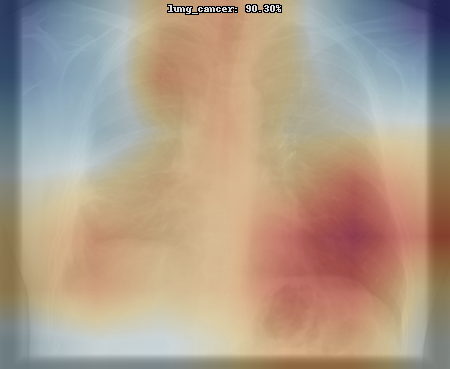

In [48]:
learn.gradcam('/data/home/xmonzonis/lung_CXR/LungX_V1/test/no_cancer/1529472_CR.1.3.51.0.7.157045018.35695.25674.37739.55492.40373.47127.jpeg')

/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default

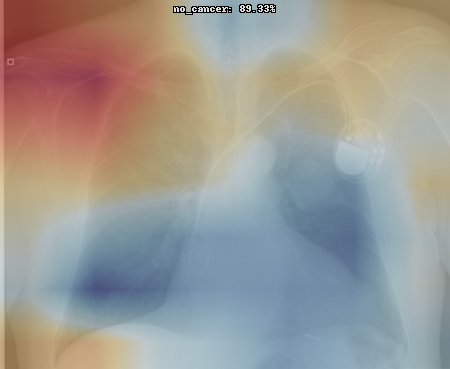

In [49]:
learn.gradcam('/data/home/xmonzonis/lung_CXR/LungX_V1/test/lung_cancer/771903_CR.1.3.51.0.7.593082280.5921.48461.33871.6322.47061.23069.jpeg')

/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default

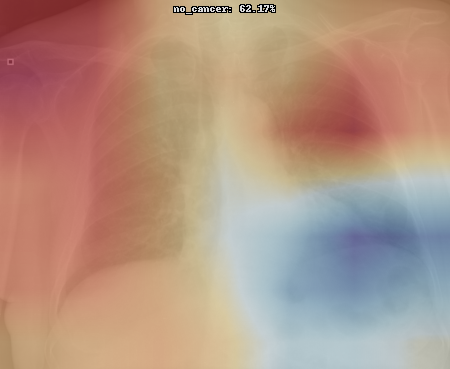

In [50]:
learn.gradcam('/data/home/xmonzonis/lung_CXR/LungX_V1/test/lung_cancer/771641_CR.1.3.51.0.7.193650084.15544.52802.45096.65297.16764.16487.jpeg')

/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default

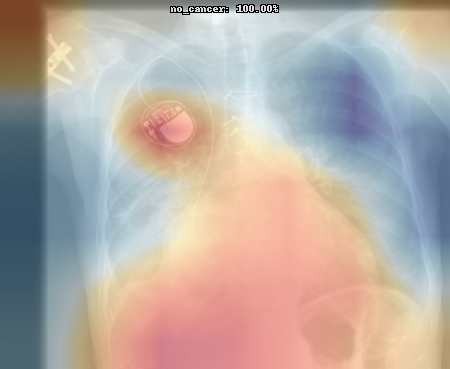

In [51]:
learn.gradcam('/data/home/xmonzonis/lung_CXR/LungX_V1/test/no_cancer/27951_CR.1.3.51.0.7.1594471544.9513.37697.48666.38107.63286.48046.jpeg')

/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/data/home/xmonzonis/.conda/envs/PyTorch_fastai_timm/lib/python3.8/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default

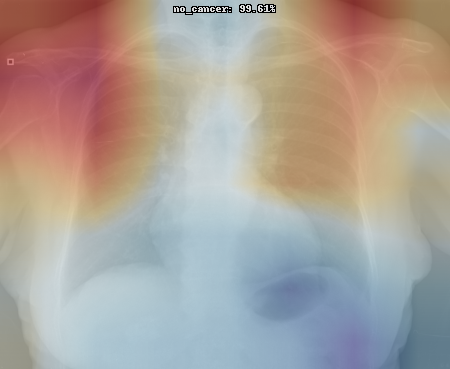

In [52]:
learn.gradcam('/data/home/xmonzonis/lung_CXR/LungX_V1/test/no_cancer/8508_CR.1.3.51.0.7.12528239438.64583.20294.34276.3050.53892.5845.jpeg')